# Anomalous diffraction theory

**Scott Prahl**

**Feb 2025**

First thing is to define some reasonably accurate approximations for the efficiencies for large spheres.  This way we can ensure that the limiting cases behaive as they should.

These formulas used below are from Moosmüller and Sorensen [Single scattering albedo of homogeneous, spherical 
particles in the transition regime](https://doi.org/10.1016/j.jqsrt.2018.08.015)

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("miepython", deps=False)
    os.environ["MIEPYTHON_USE_JIT"] = "0"  # jupyterlite cannot use numba

import miepython as mie

In [2]:
def Qabs_adt(m, x):
    """
    Anomalous diffraction theory approximation for absorption efficiency.
    """
    kappa = abs(m.imag)

    if kappa == 0:
        return np.zeros_like(x)
    return 1 + 2 * np.exp(-4 * kappa * x) / (4 * kappa * x) + 2 * (np.exp(-4 * kappa * x) - 1) / (4 * kappa * x) ** 2


def Qext_adt(m, x):
    """
    Anomalous diffraction theory approximation for extinction efficiency.
    """
    n = m.real
    kappa = abs(m.imag)
    rho = 2 * x * np.abs(m - 1)
    beta = np.arctan2(kappa, n - 1)
    ex = np.exp(-rho * np.tan(beta))

    qext_adt = 2
    qext_adt += -4 * ex * np.cos(beta) / rho * np.sin(rho - beta)
    qext_adt += -4 * ex * np.cos(beta) ** 2 / rho**2 * np.cos(rho - 2 * beta)
    qext_adt += 4 * np.cos(beta) ** 2 / rho**2 * np.cos(2 * beta)
    return qext_adt


def Qabs_madt(m, x):
    """
    Modified anomalous diffraction theory approximation for absorption efficiency.
    """
    n = m.real
    kappa = abs(m.imag)

    if kappa == 0:
        return np.zeros_like(x)

    qabs_adt = Qabs_adt(m, x)
    epsilon = 0.25 + 0.61 * (1 - np.exp(-8 * np.pi / 3 * kappa)) ** 2
    c1 = 0.25 * (1 + np.exp(-1167 * kappa)) * (1 - qabs_adt)
    c2 = np.sqrt(2 * epsilon * x / np.pi) * np.exp(0.5 - epsilon * x / np.pi) * (0.7393 * n - 0.6069)
    return (1 + c1 + c2) * qabs_adt


def Qext_madt(m, x):
    """
    Modified anomalous diffraction theory approximation for extinction efficiency.
    """
    n = m.real
    kappa = -np.imag(m)

    qext_adt = Qext_adt(m, x)
    epsilon = 0.25 + 0.61 * (1 - np.exp(-8 * np.pi / 3 * kappa)) ** 2
    c2 = np.sqrt(2 * epsilon * x / np.pi) * np.exp(0.5 - epsilon * x / np.pi) * (0.7393 * n - 0.6069)
    Qedge = (1 - np.exp(-0.06 * x)) * x ** (-2 / 3)

    return (1 + 0.5 * c2) * qext_adt + Qedge

## No Absorption Case `m=1.5`

In [3]:
m = 1.5
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
qabs = qext - qsca

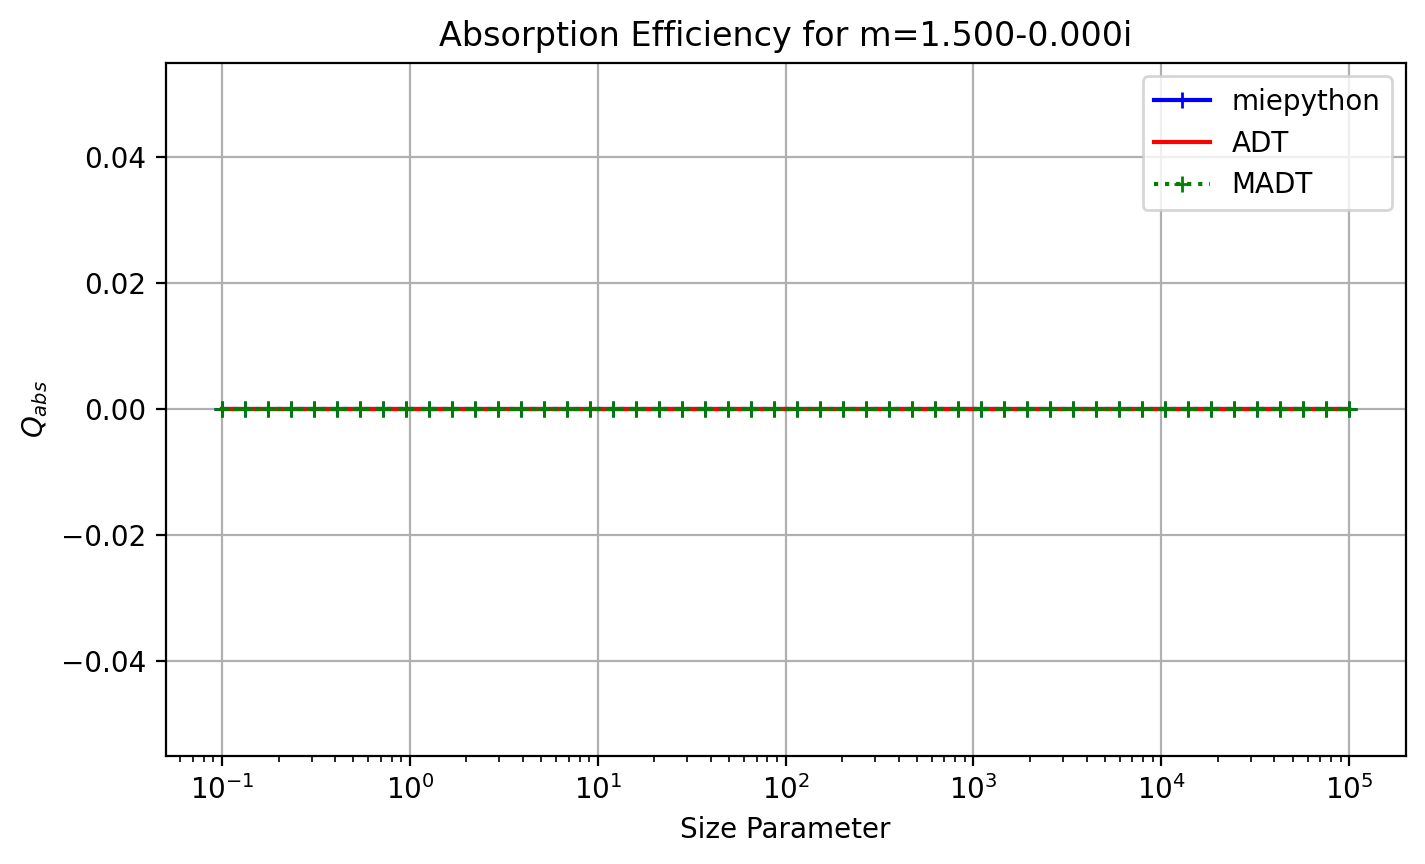

In [4]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qabs, "b-+", label="miepython")
plt.semilogx(x, Qabs_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qabs_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

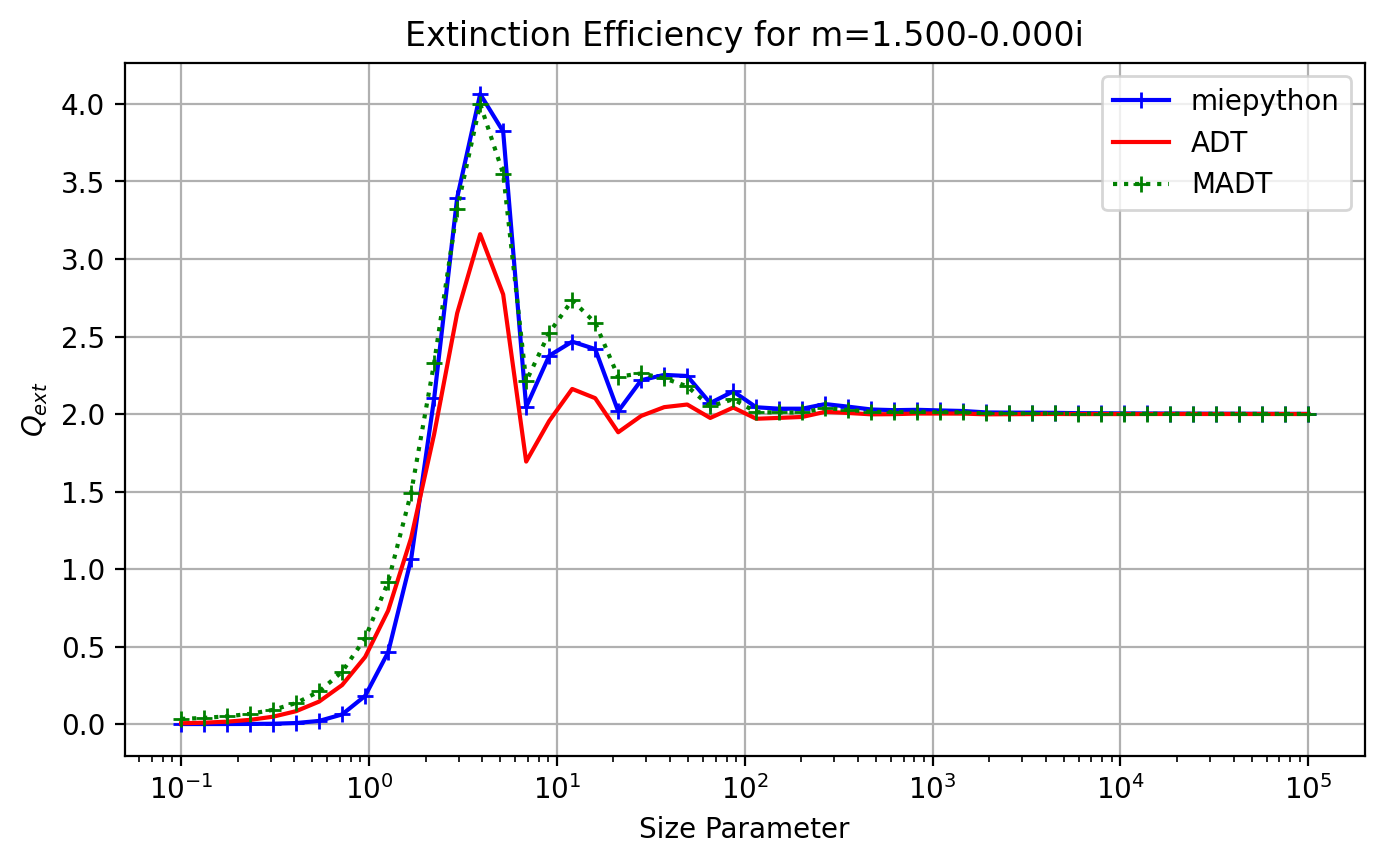

In [5]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext, "b-+", label="miepython")
plt.semilogx(x, Qext_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qext_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

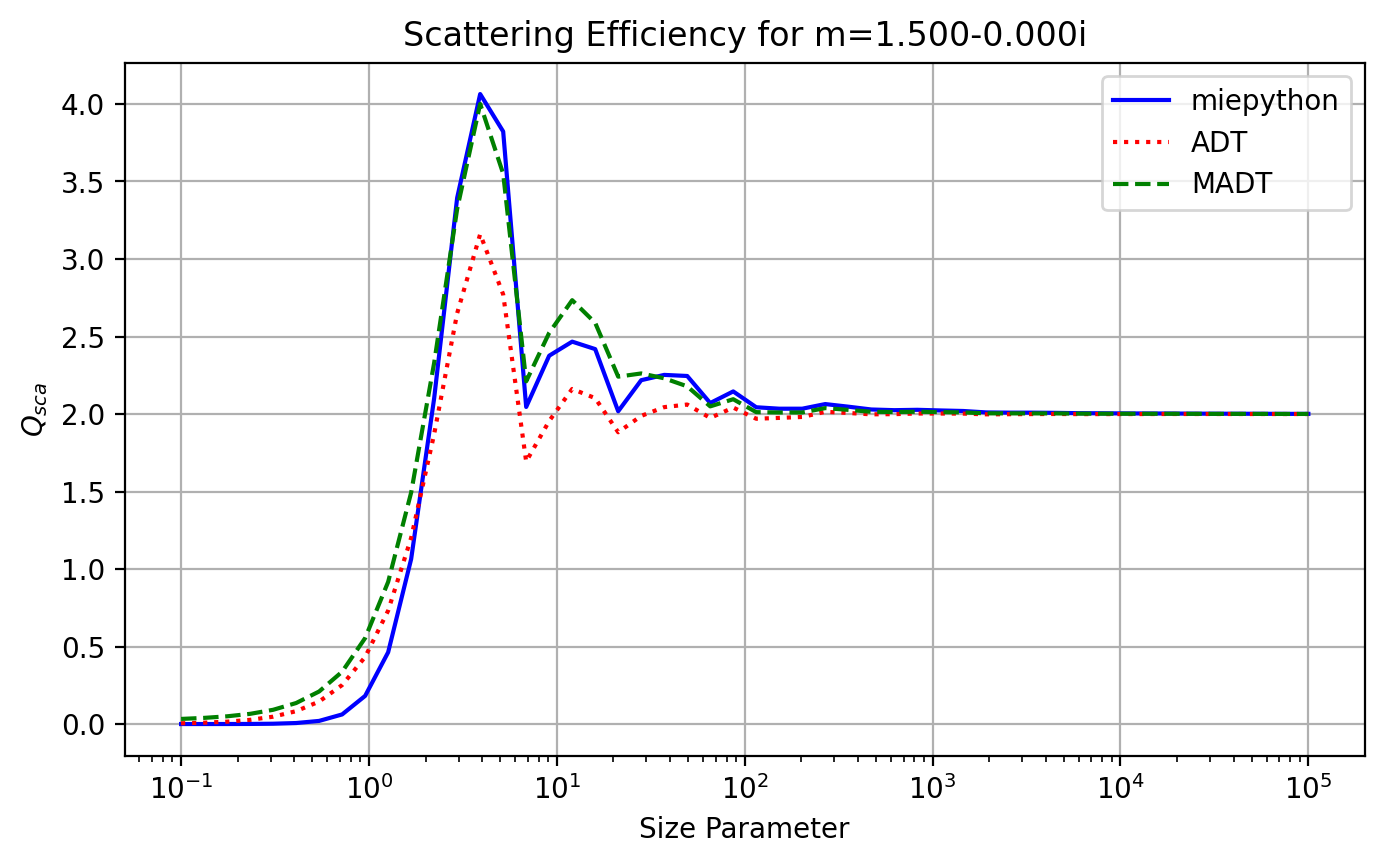

In [6]:
Qsca_adt = Qext_adt(m, x) - Qabs_adt(m, x)
Qsca_madt = Qext_madt(m, x) - Qabs_madt(m, x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qsca, "b", label="miepython")
plt.semilogx(x, Qsca_adt, "r:", label="ADT")
plt.semilogx(x, Qsca_madt, "g--", label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

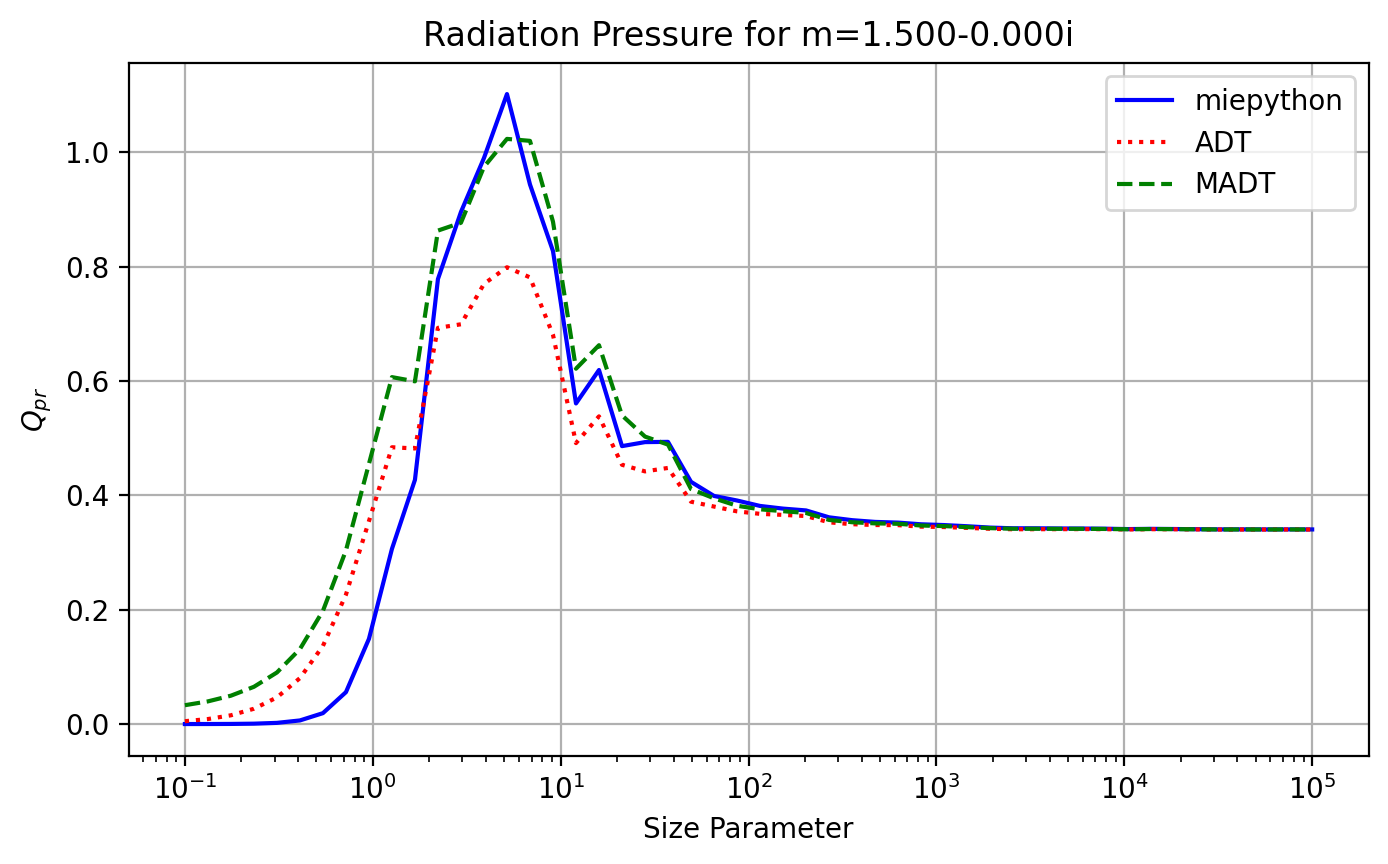

In [7]:
Qpr_adt = Qext_adt(m, x) - g * Qsca_adt
Qpr_madt = Qext_madt(m, x) - g * Qsca_madt

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext - g * qsca, "b", label="miepython")
plt.semilogx(x, Qpr_adt, "r:", label="ADT")
plt.semilogx(x, Qpr_madt, "g--", label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

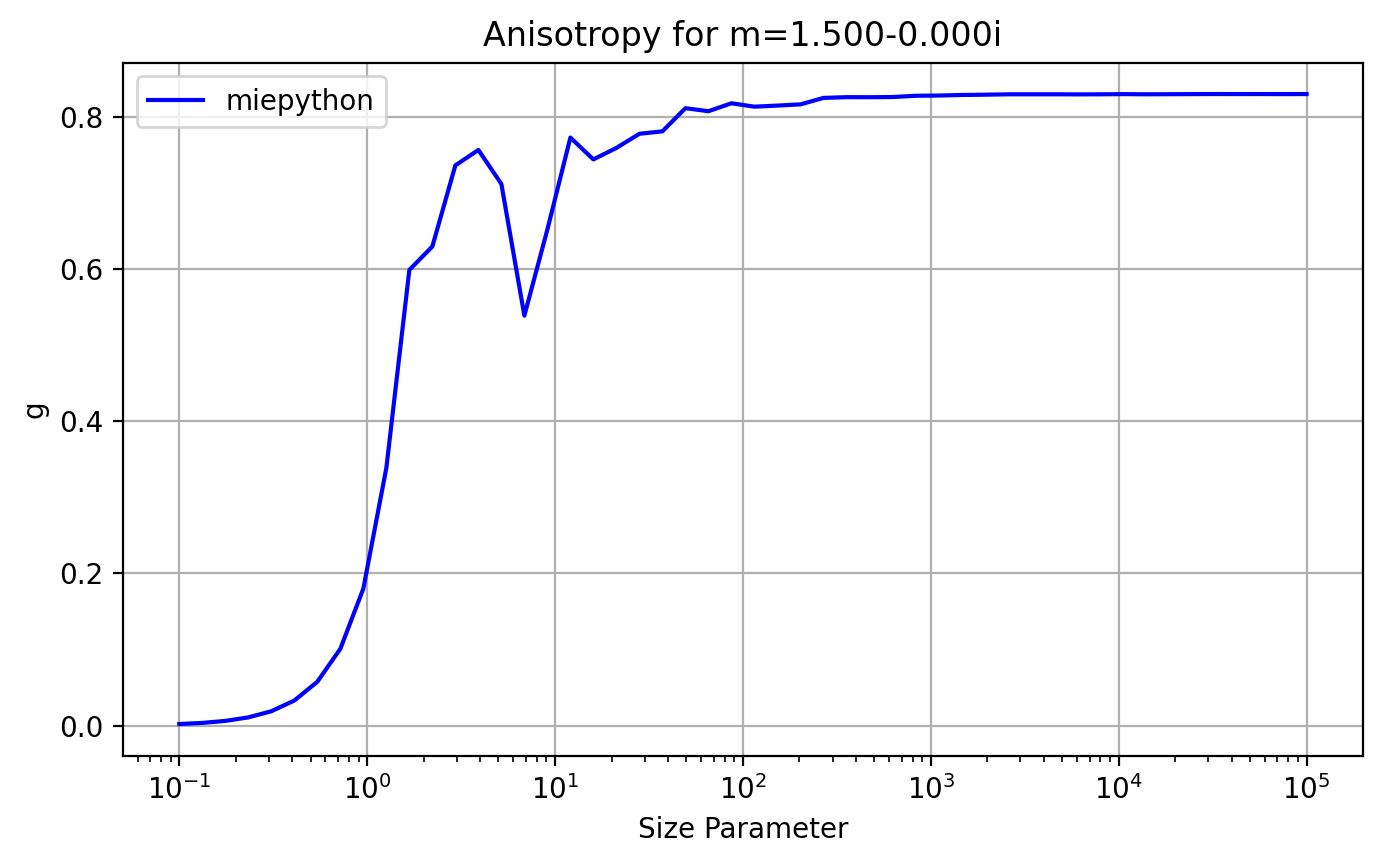

In [8]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, g, "b", label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

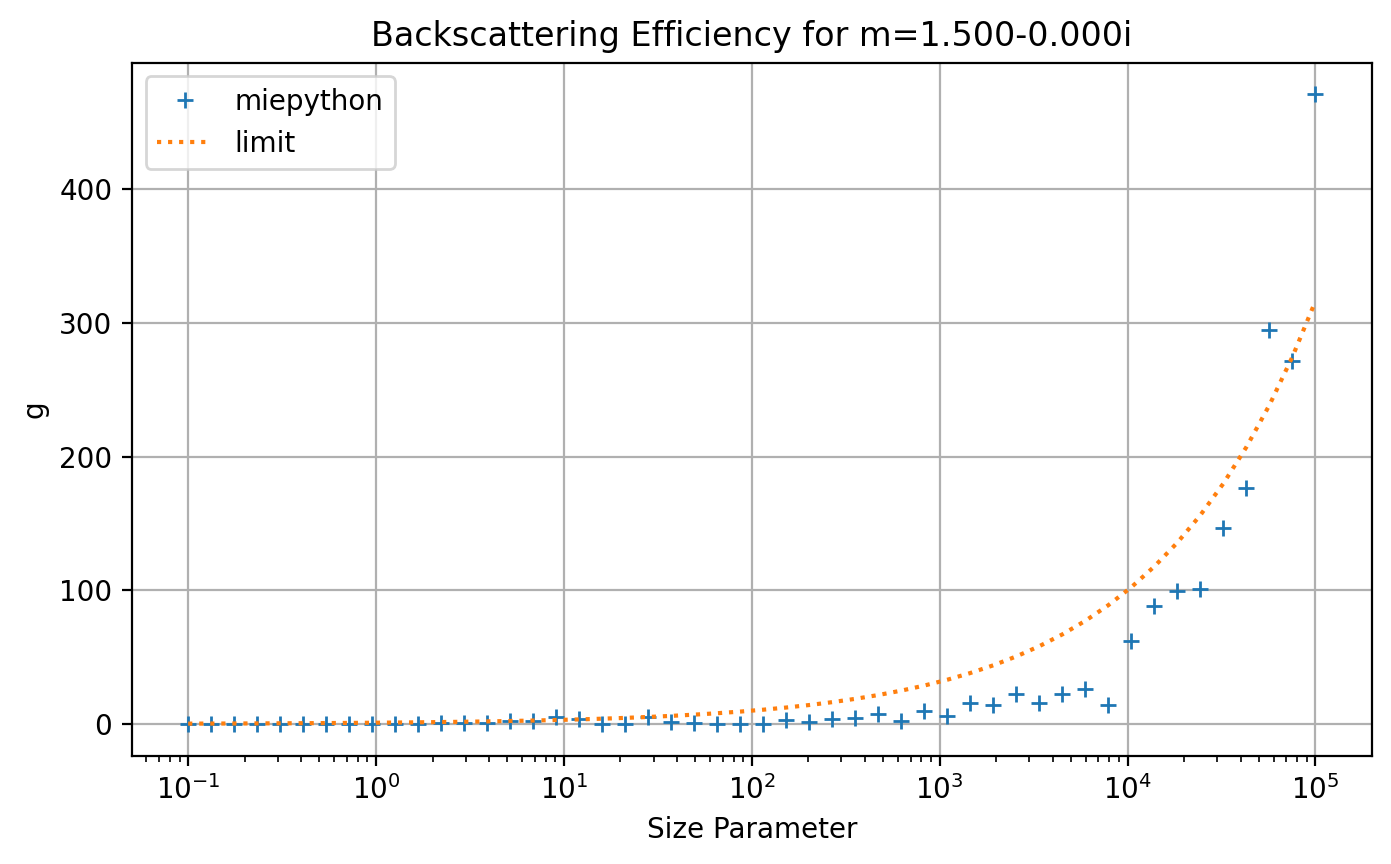

In [9]:
## No absorption means that the argument that the backscatter
## efficiency goes as the surface reflection fails.  See 09_backscatter.ipynb
## for tests that show that miepython correctly calculates qback

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qback, "+", label="miepython")
plt.semilogx(x, x**0.5, ":", label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

## A little absorption `m=1.5-0.001j`

In [10]:
m = 1.5 - 0.001j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
qabs = qext - qsca

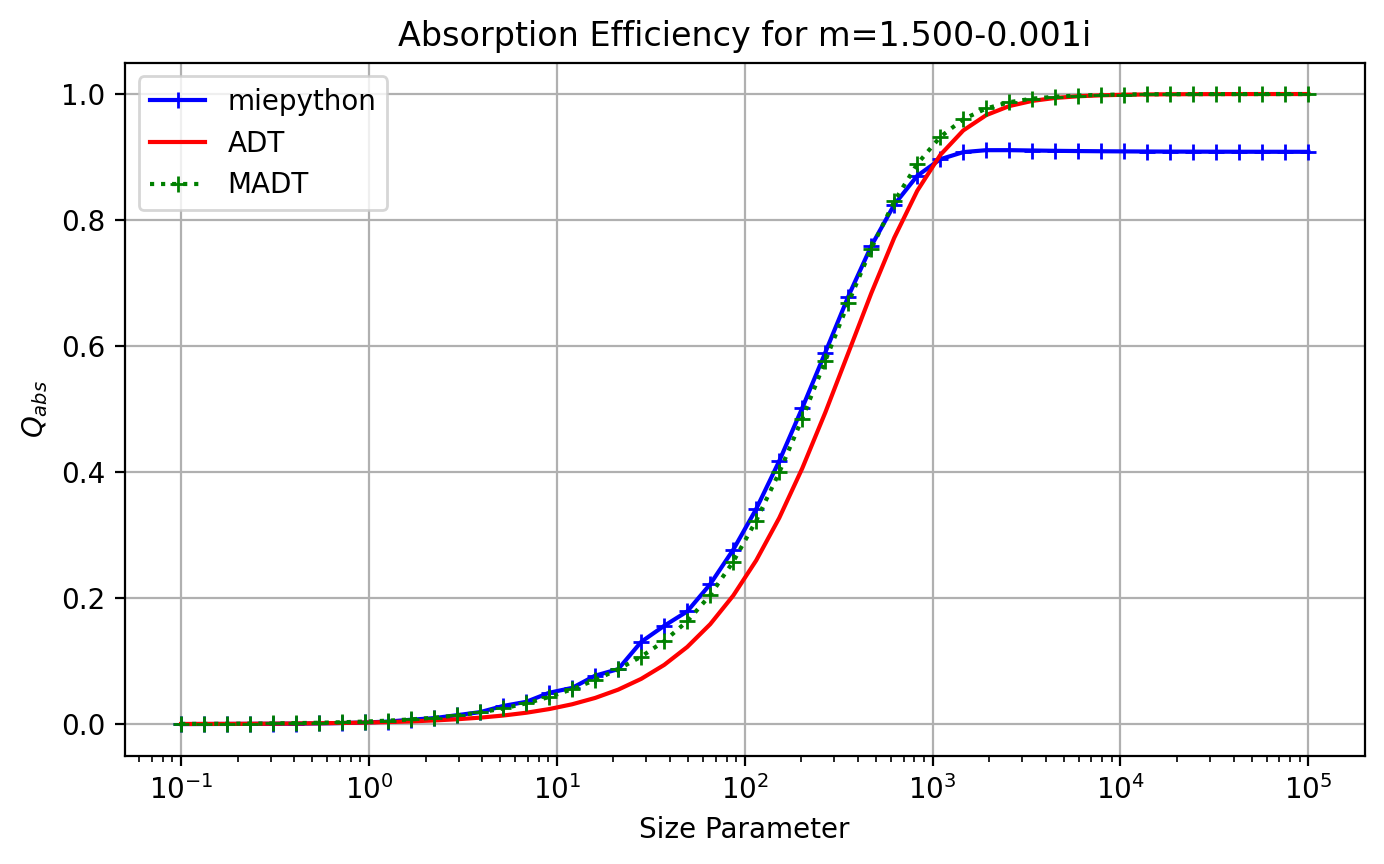

In [11]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qabs, "b-+", label="miepython")
plt.semilogx(x, Qabs_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qabs_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

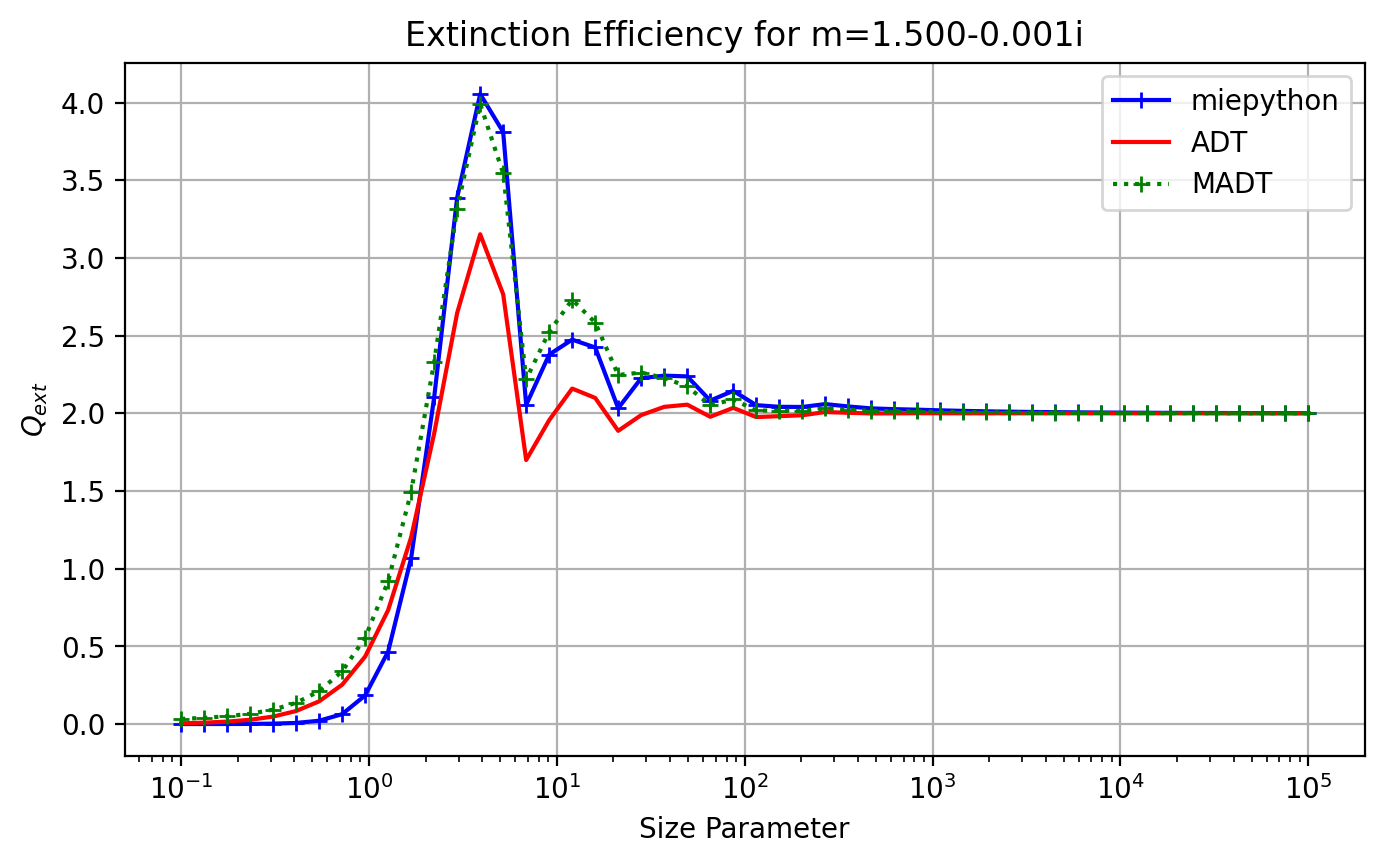

In [12]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext, "b-+", label="miepython")
plt.semilogx(x, Qext_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qext_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

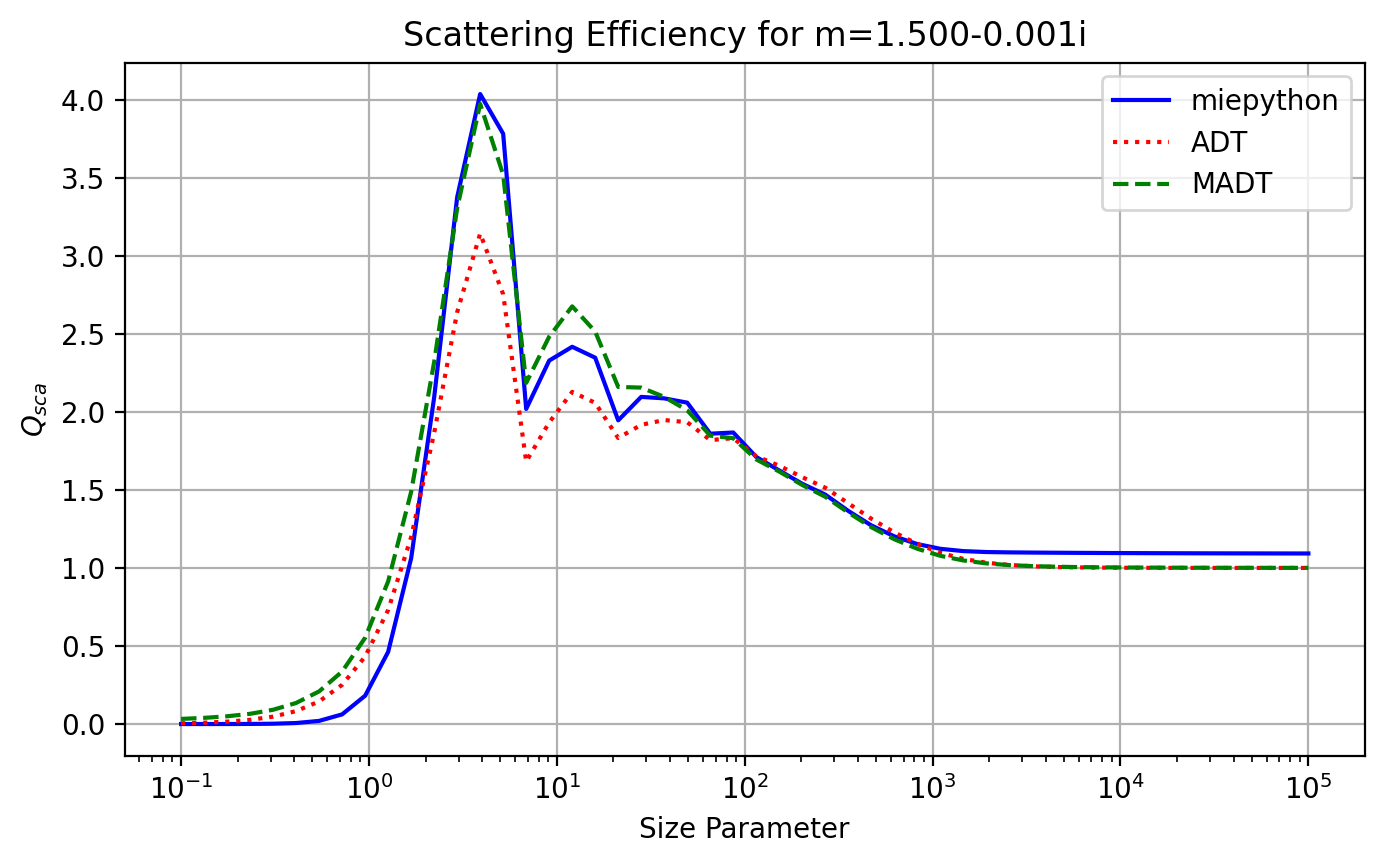

In [13]:
Qsca_adt = Qext_adt(m, x) - Qabs_adt(m, x)
Qsca_madt = Qext_madt(m, x) - Qabs_madt(m, x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qsca, "b", label="miepython")
plt.semilogx(x, Qsca_adt, "r:", label="ADT")
plt.semilogx(x, Qsca_madt, "g--", label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

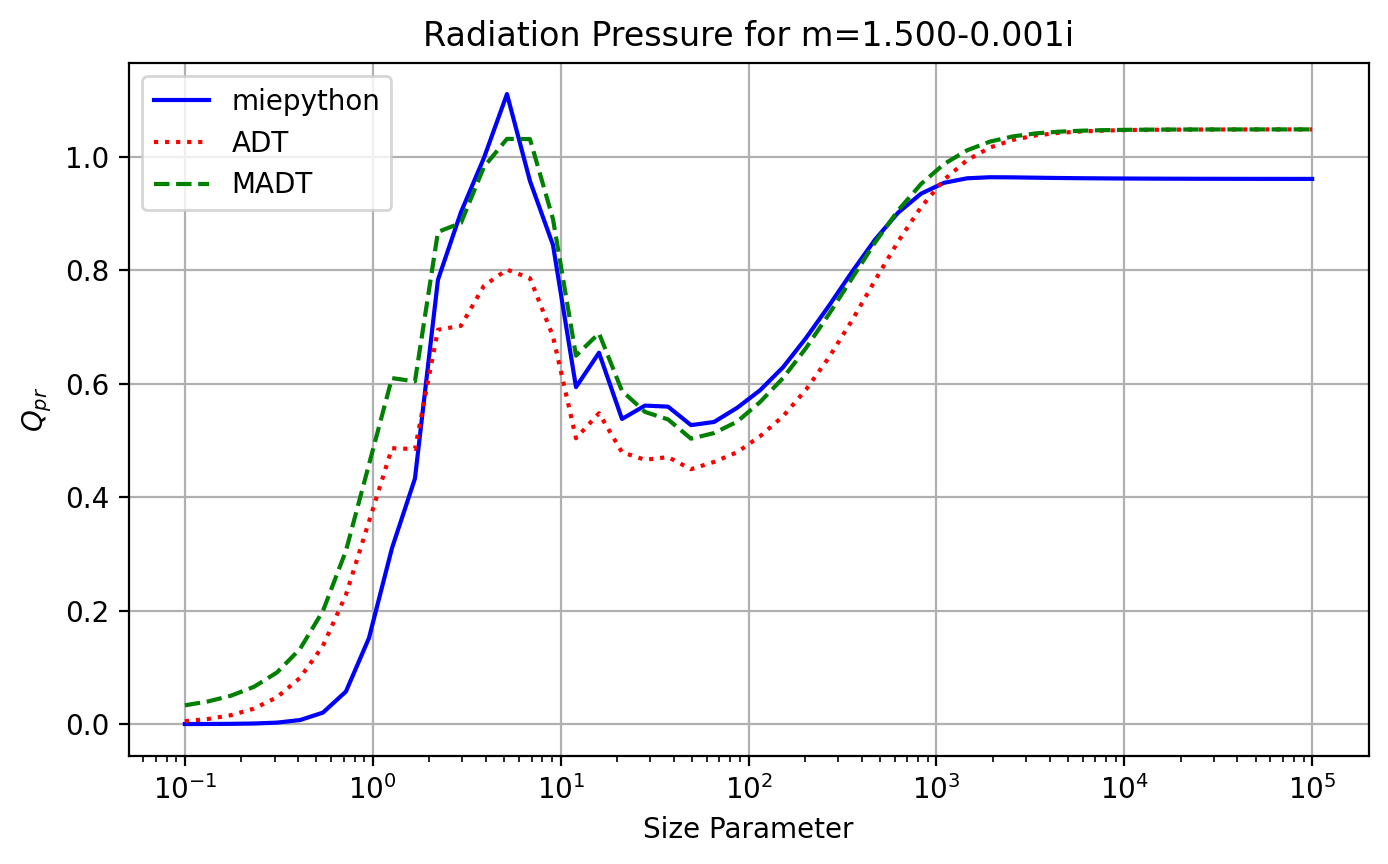

In [14]:
Qpr_adt = Qext_adt(m, x) - g * Qsca_adt
Qpr_madt = Qext_madt(m, x) - g * Qsca_madt

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext - g * qsca, "b", label="miepython")
plt.semilogx(x, Qpr_adt, "r:", label="ADT")
plt.semilogx(x, Qpr_madt, "g--", label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

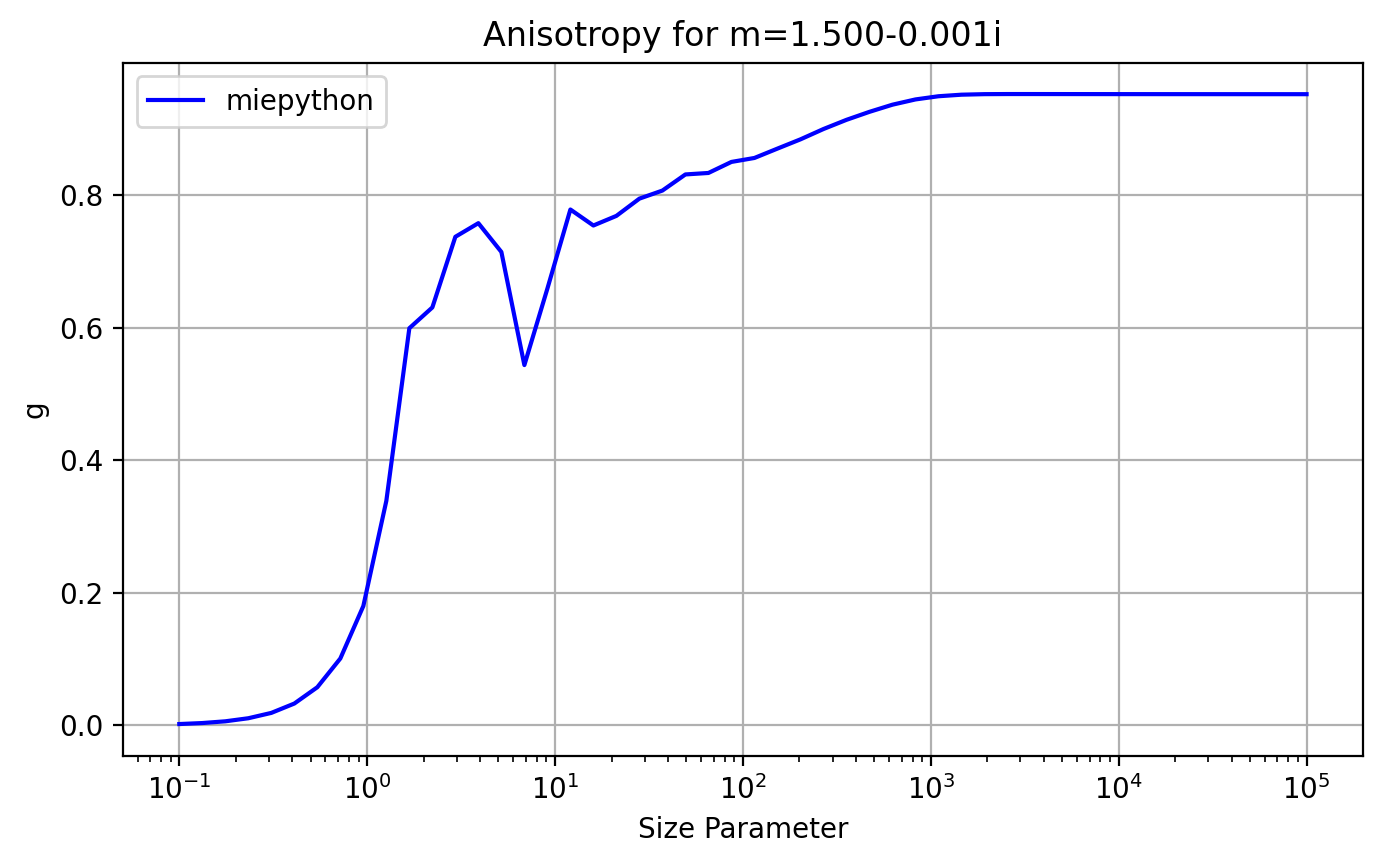

In [15]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, g, "b", label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

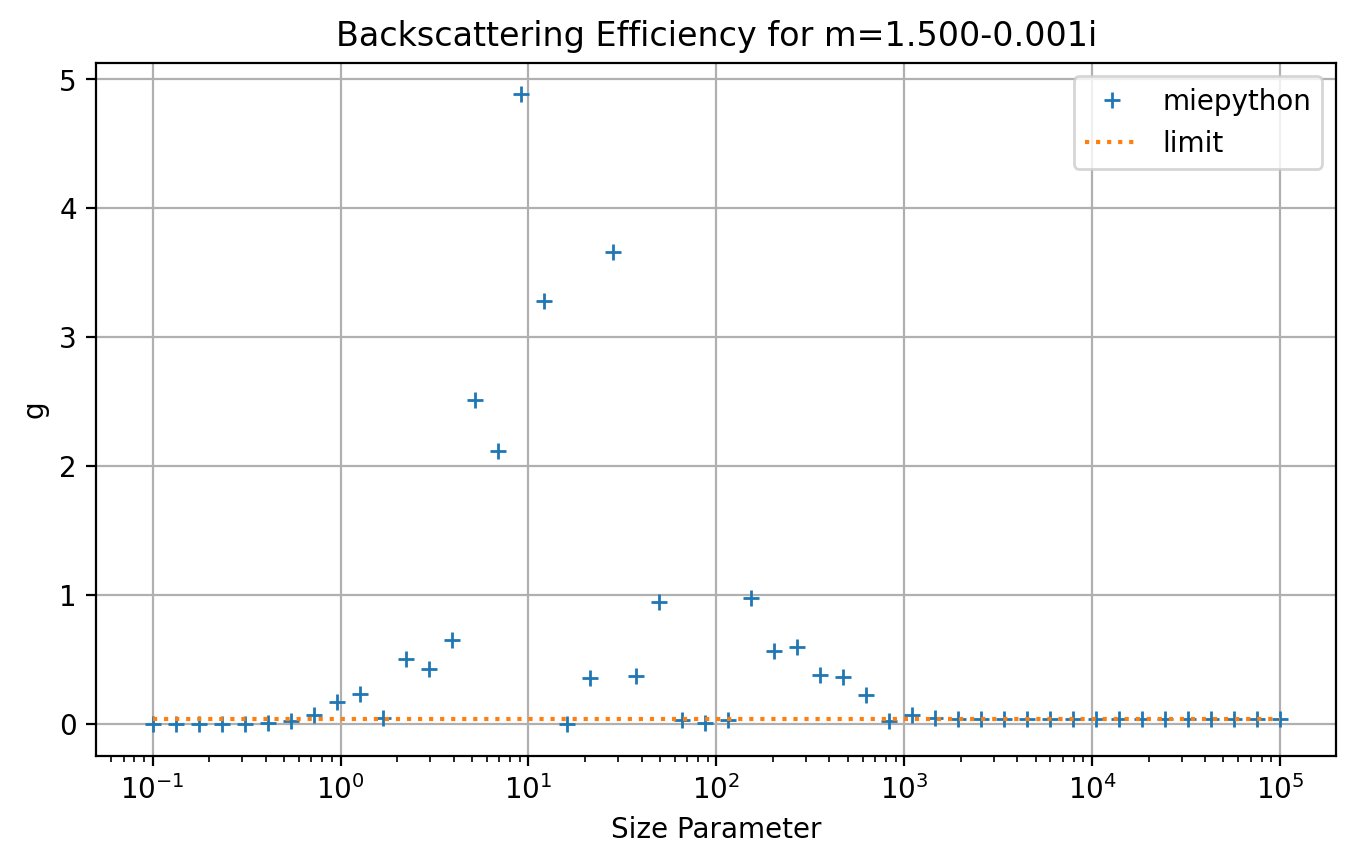

In [16]:
Qbacks = abs(m - 1) ** 2 / abs(m + 1) ** 2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qback, "+", label="miepython")
plt.semilogx(x, Qback, ":", label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

## Some Absorption `m=1.5-0.1j`

In [17]:
m = 1.5 - 0.1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
qabs = qext - qsca

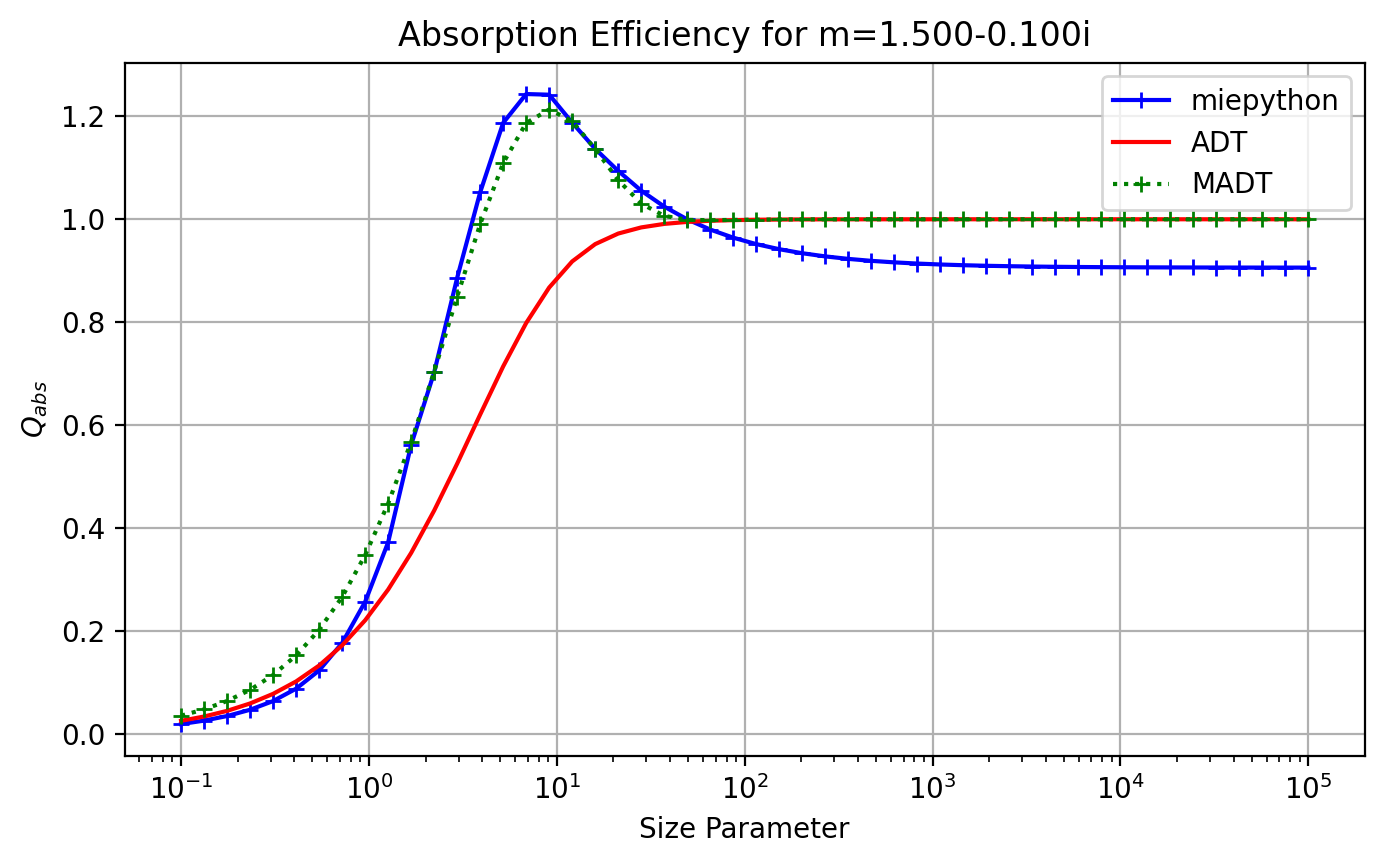

In [18]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qabs, "b-+", label="miepython")
plt.semilogx(x, Qabs_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qabs_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

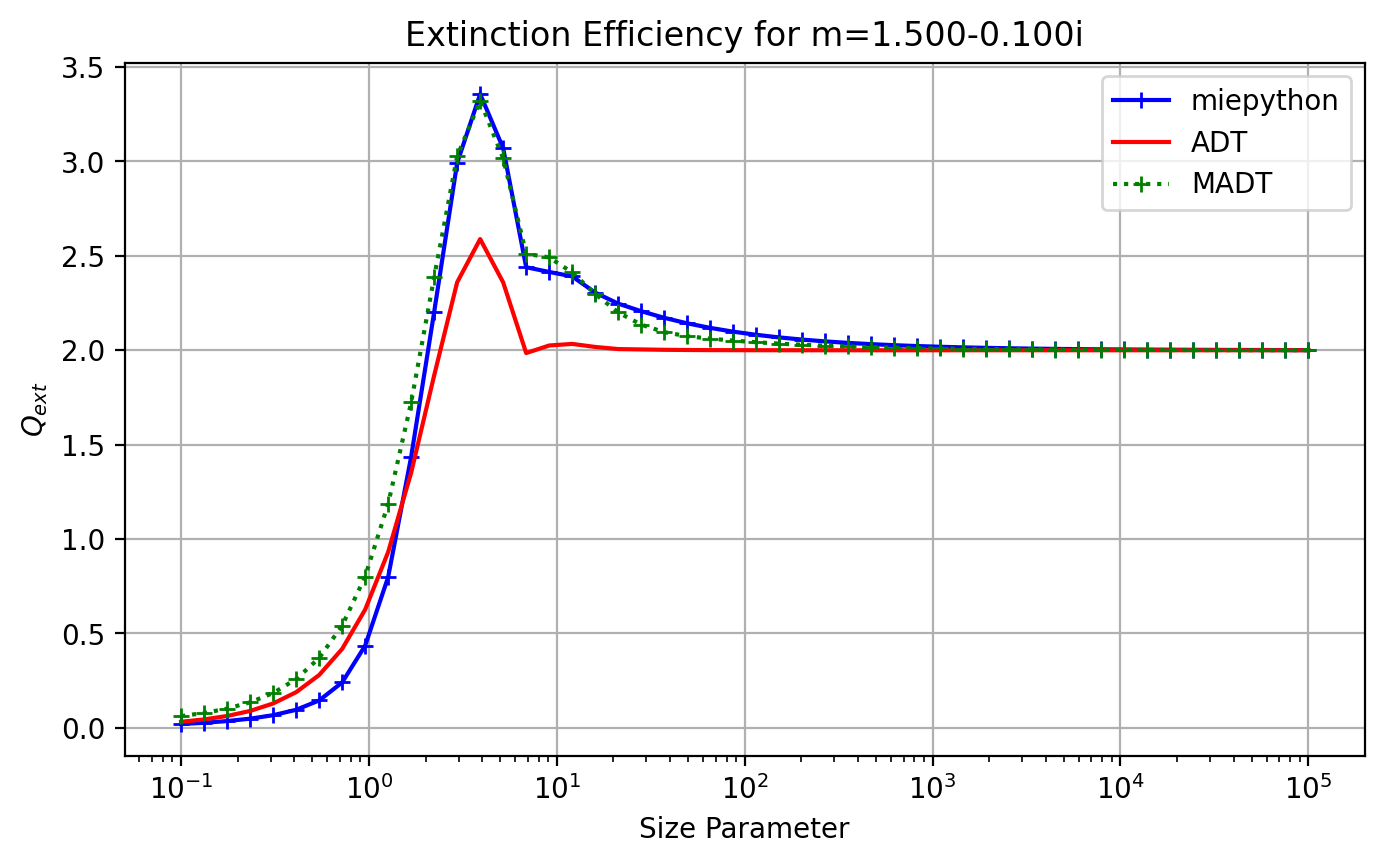

In [19]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext, "b-+", label="miepython")
plt.semilogx(x, Qext_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qext_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

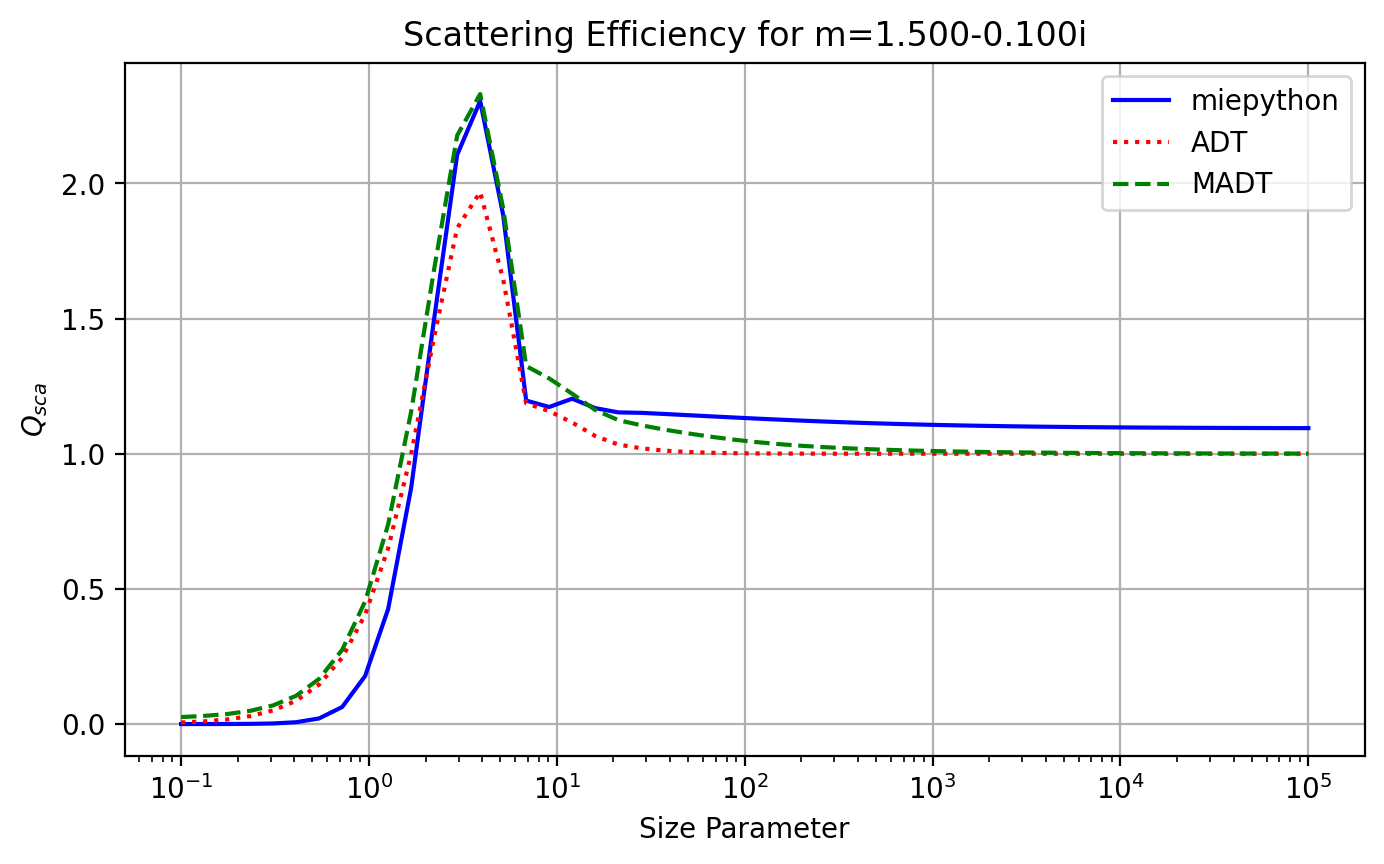

In [20]:
Qsca_adt = Qext_adt(m, x) - Qabs_adt(m, x)
Qsca_madt = Qext_madt(m, x) - Qabs_madt(m, x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qsca, "b", label="miepython")
plt.semilogx(x, Qsca_adt, "r:", label="ADT")
plt.semilogx(x, Qsca_madt, "g--", label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

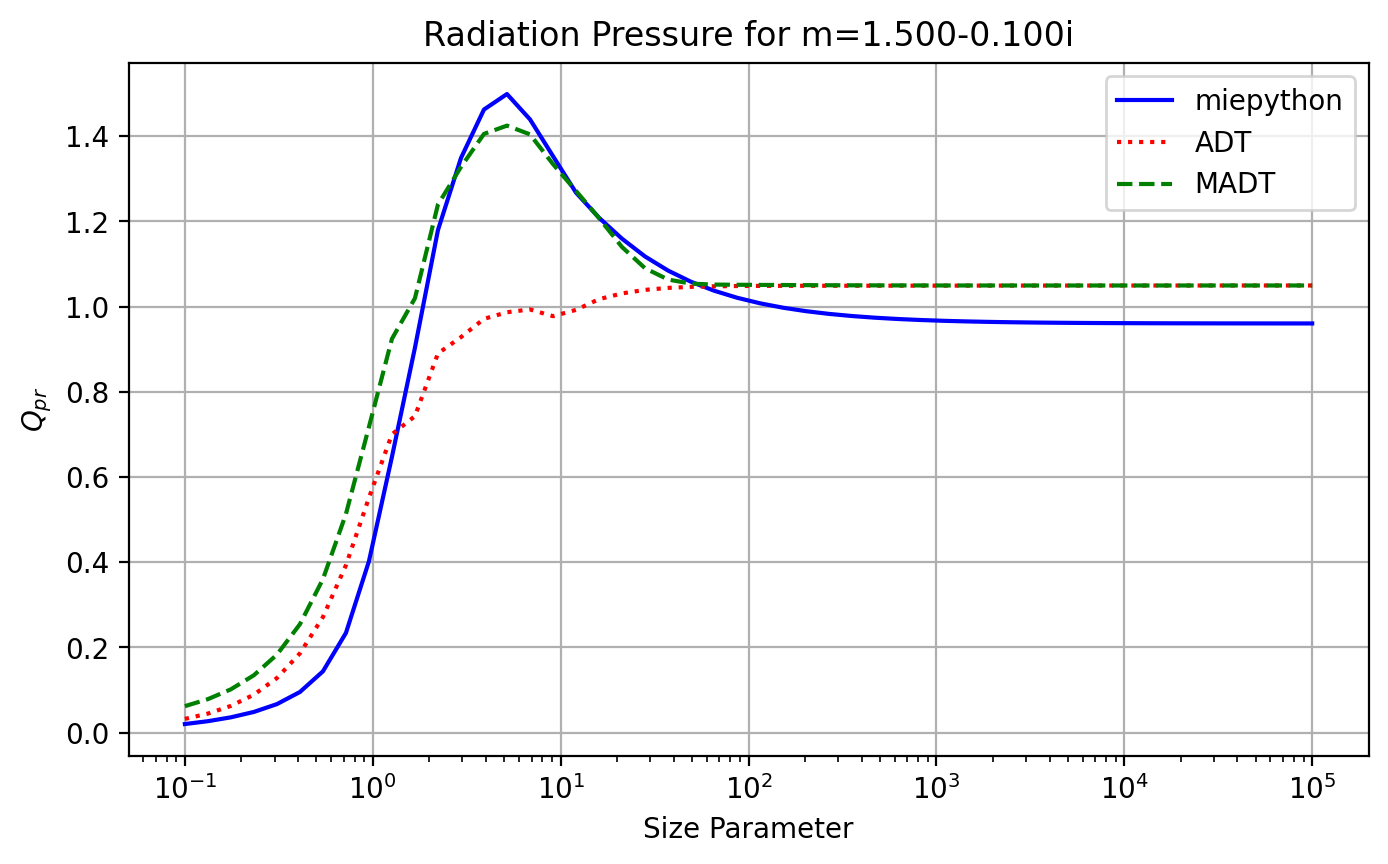

In [21]:
Qpr_adt = Qext_adt(m, x) - g * Qsca_adt
Qpr_madt = Qext_madt(m, x) - g * Qsca_madt

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext - g * qsca, "b", label="miepython")
plt.semilogx(x, Qpr_adt, "r:", label="ADT")
plt.semilogx(x, Qpr_madt, "g--", label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

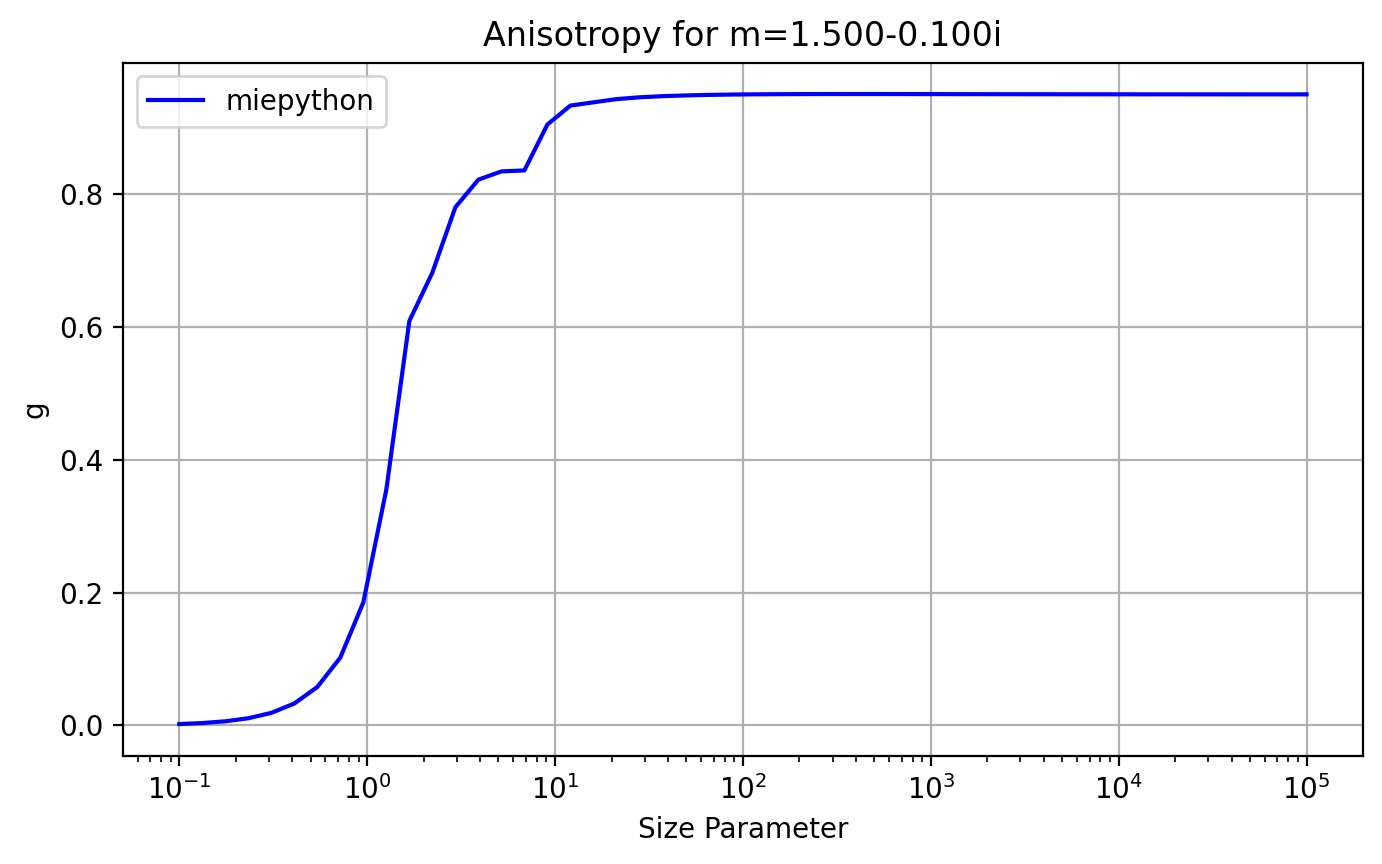

In [22]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, g, "b", label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

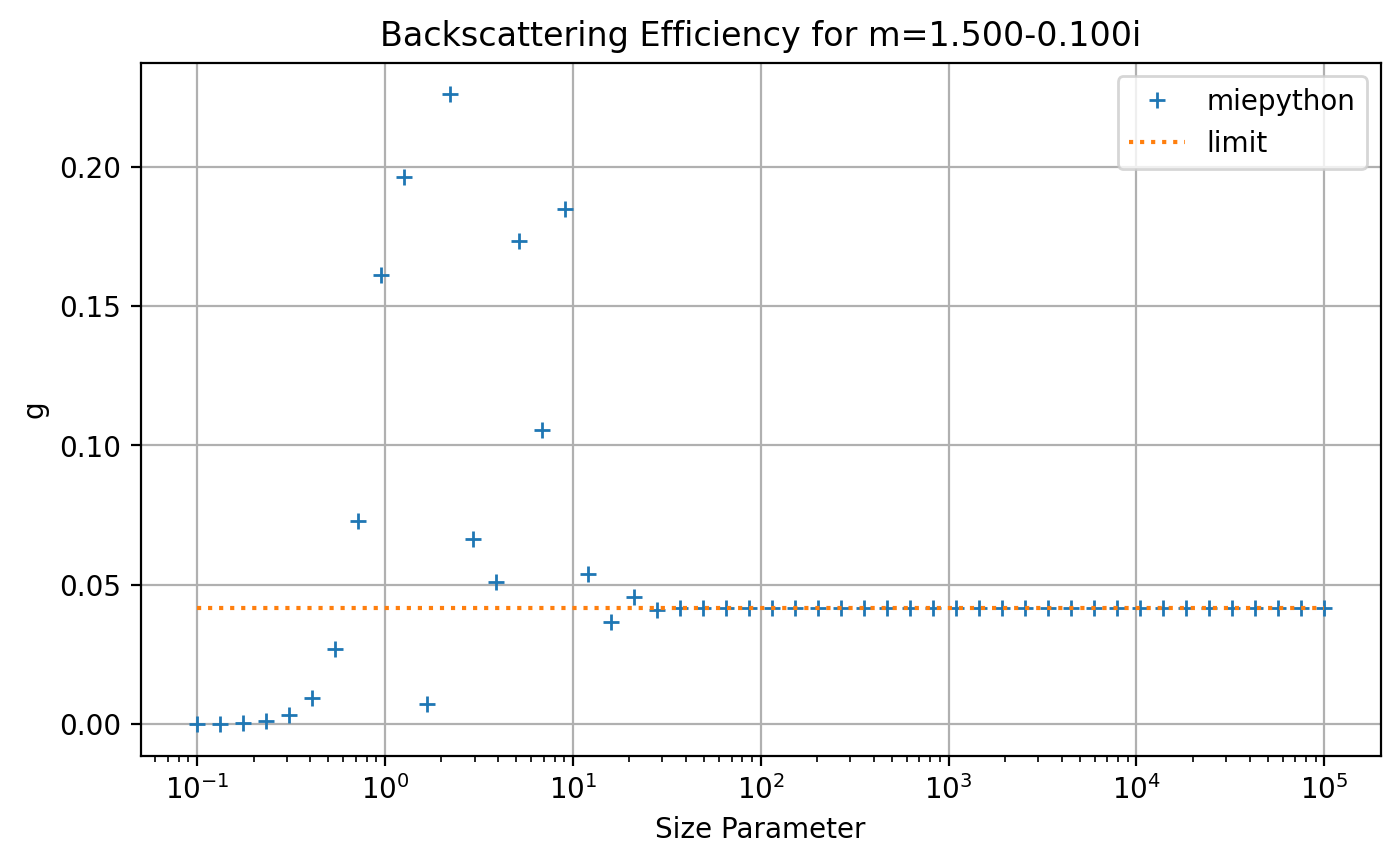

In [23]:
Qbacks = abs(m - 1) ** 2 / abs(m + 1) ** 2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qback, "+", label="miepython")
plt.semilogx(x, Qback, ":", label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

## A lot of absorption `m=1.5-1j`

In [24]:
m = 1.5 - 1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
qabs = qext - qsca

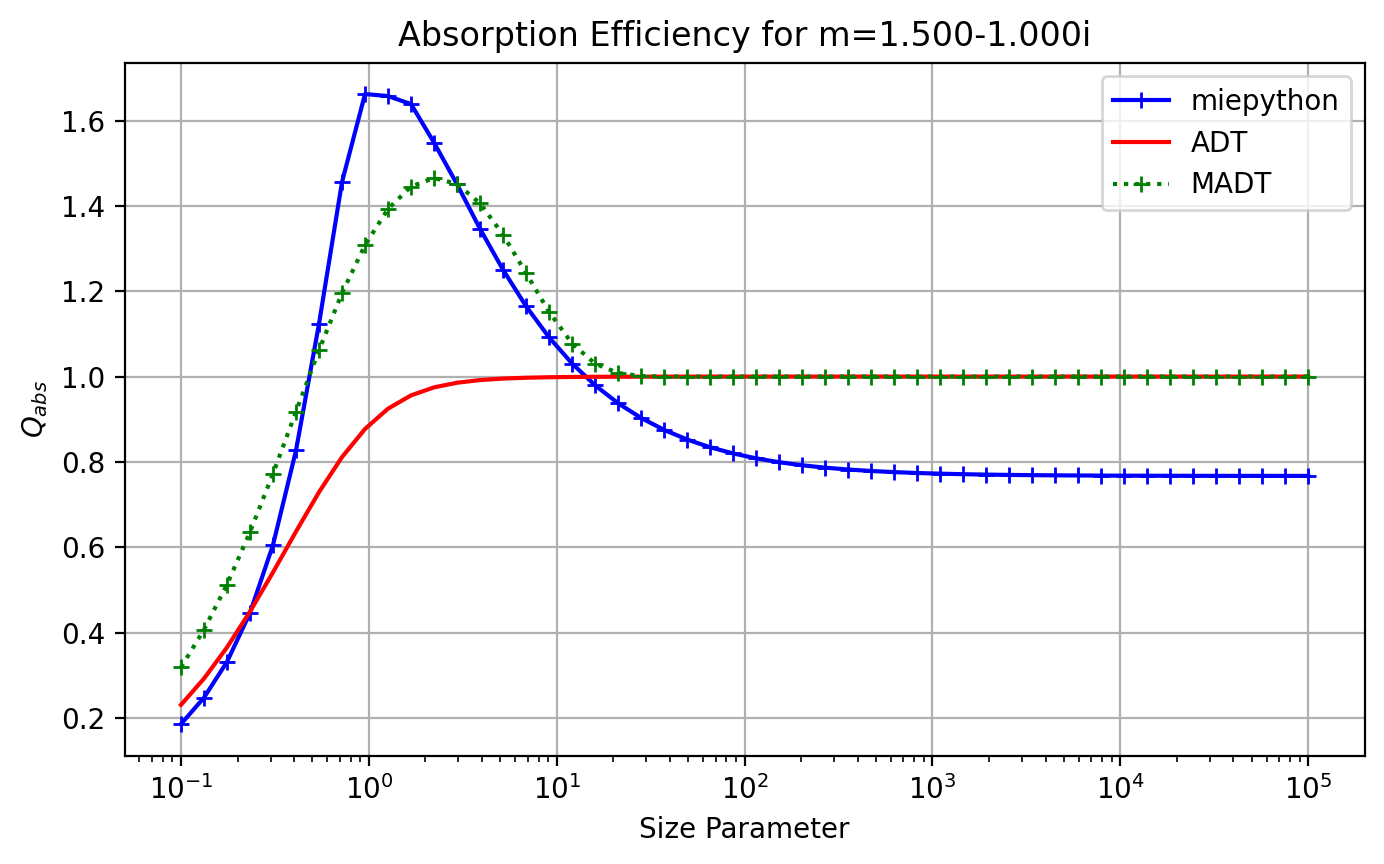

In [25]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qabs, "b-+", label="miepython")
plt.semilogx(x, Qabs_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qabs_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{abs}$")

plt.xlabel("Size Parameter")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

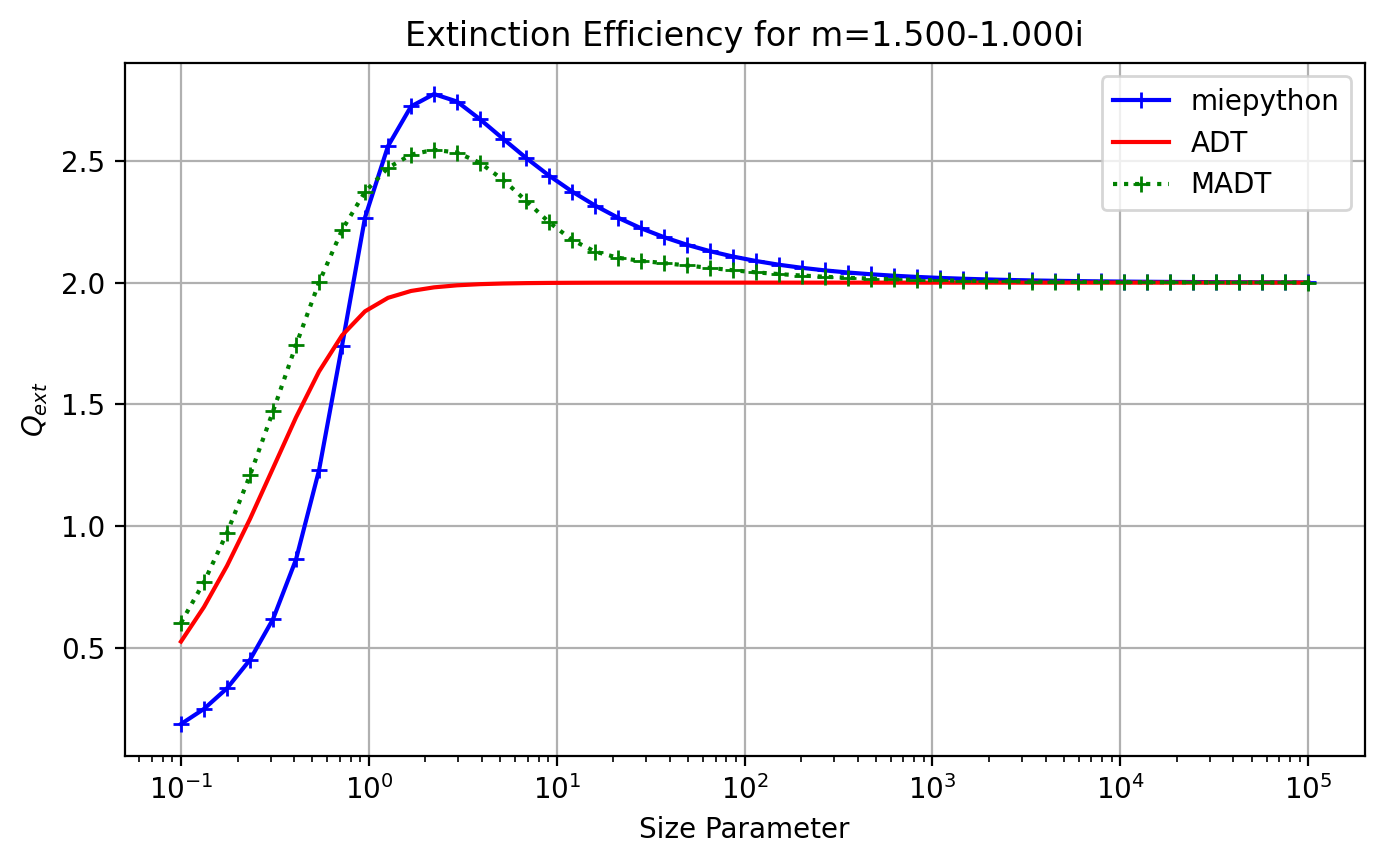

In [26]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext, "b-+", label="miepython")
plt.semilogx(x, Qext_adt(m, x), "r", label="ADT")
plt.semilogx(x, Qext_madt(m, x), "g+:", label="MADT")

plt.ylabel("$Q_{ext}$")

plt.xlabel("Size Parameter")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

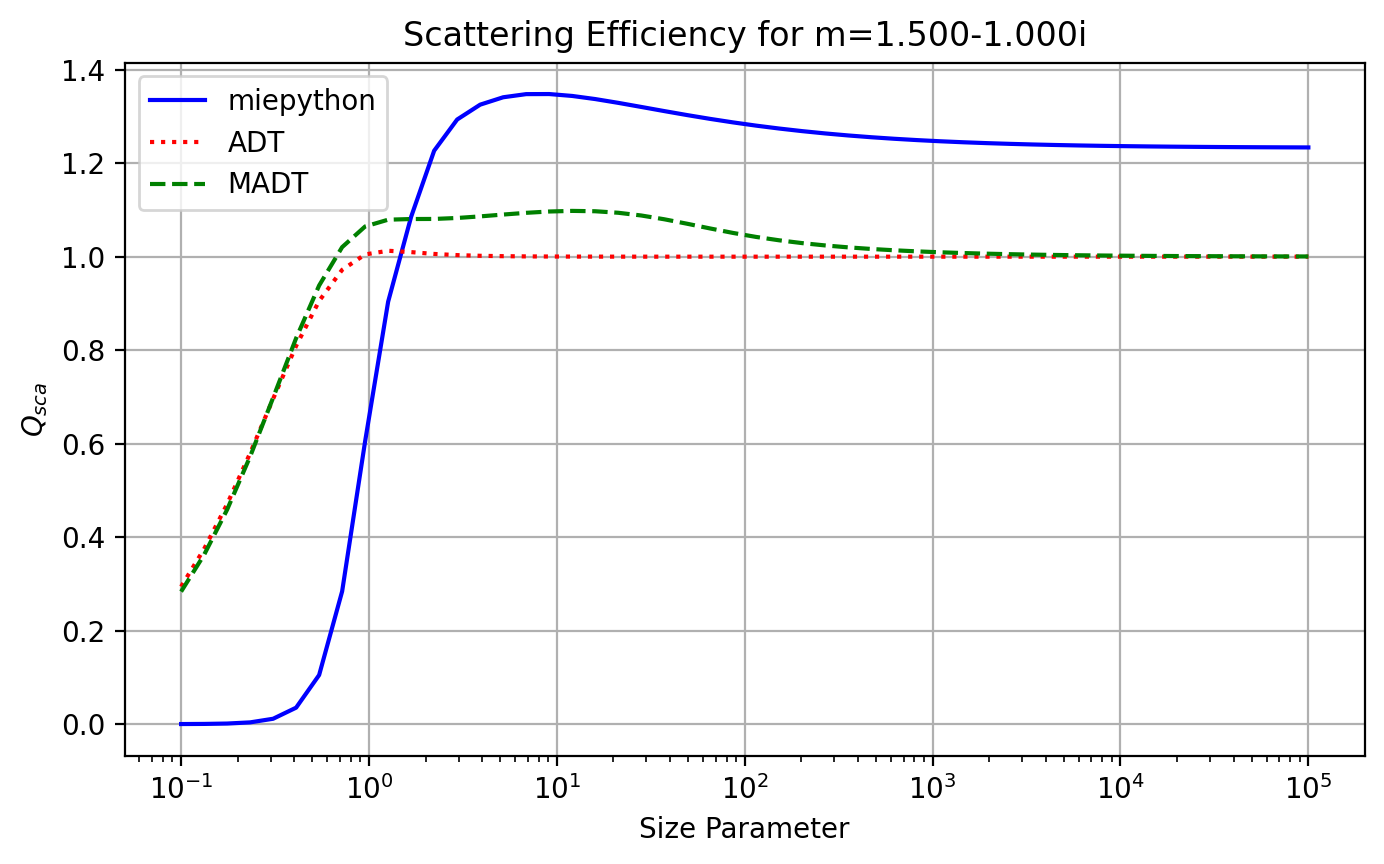

In [27]:
Qsca_adt = Qext_adt(m, x) - Qabs_adt(m, x)
Qsca_madt = Qext_madt(m, x) - Qabs_madt(m, x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qsca, "b", label="miepython")
plt.semilogx(x, Qsca_adt, "r:", label="ADT")
plt.semilogx(x, Qsca_madt, "g--", label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

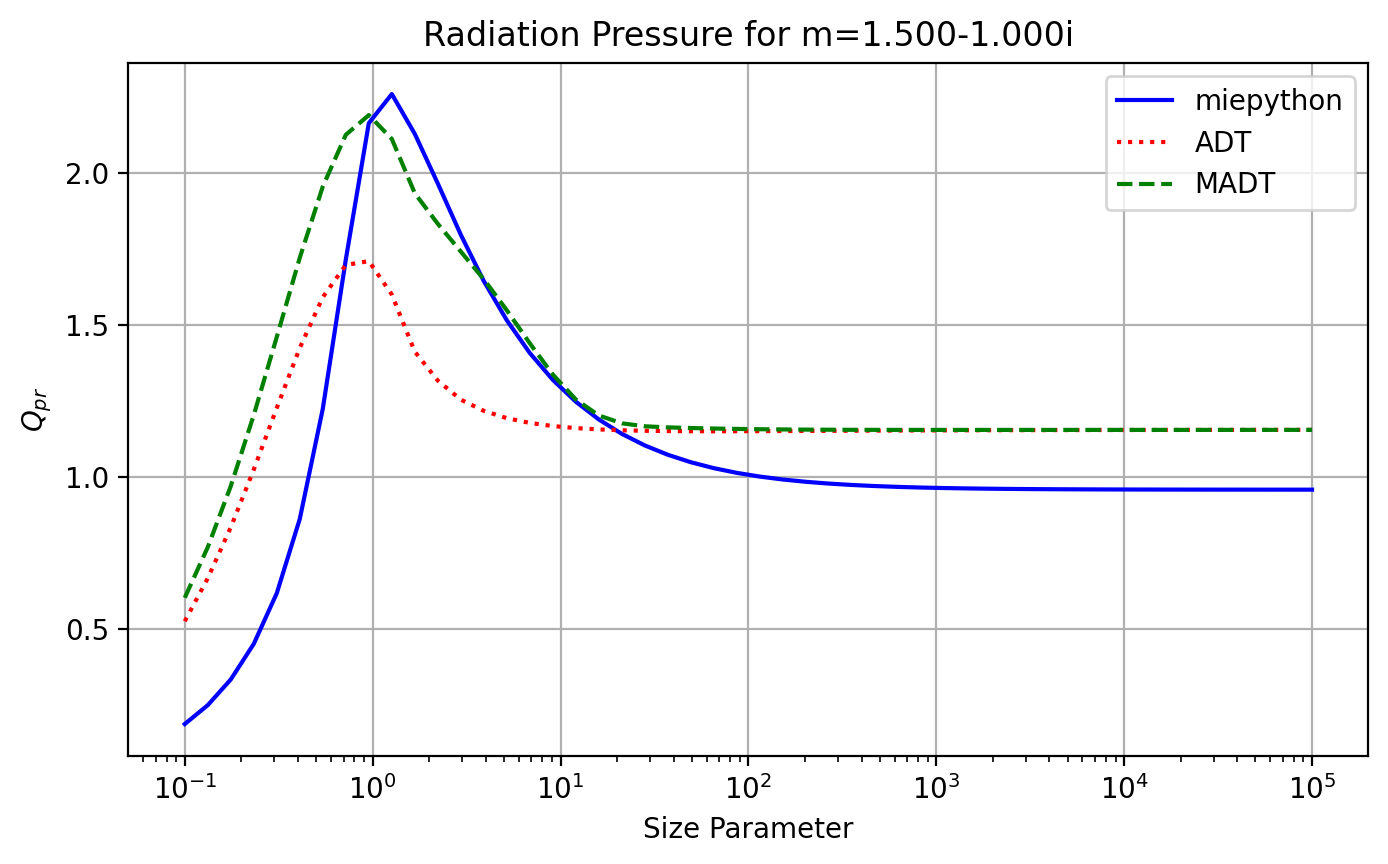

In [28]:
Qpr_adt = Qext_adt(m, x) - g * Qsca_adt
Qpr_madt = Qext_madt(m, x) - g * Qsca_madt

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qext - g * qsca, "b", label="miepython")
plt.semilogx(x, Qpr_adt, "r:", label="ADT")
plt.semilogx(x, Qpr_madt, "g--", label="MADT")


plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

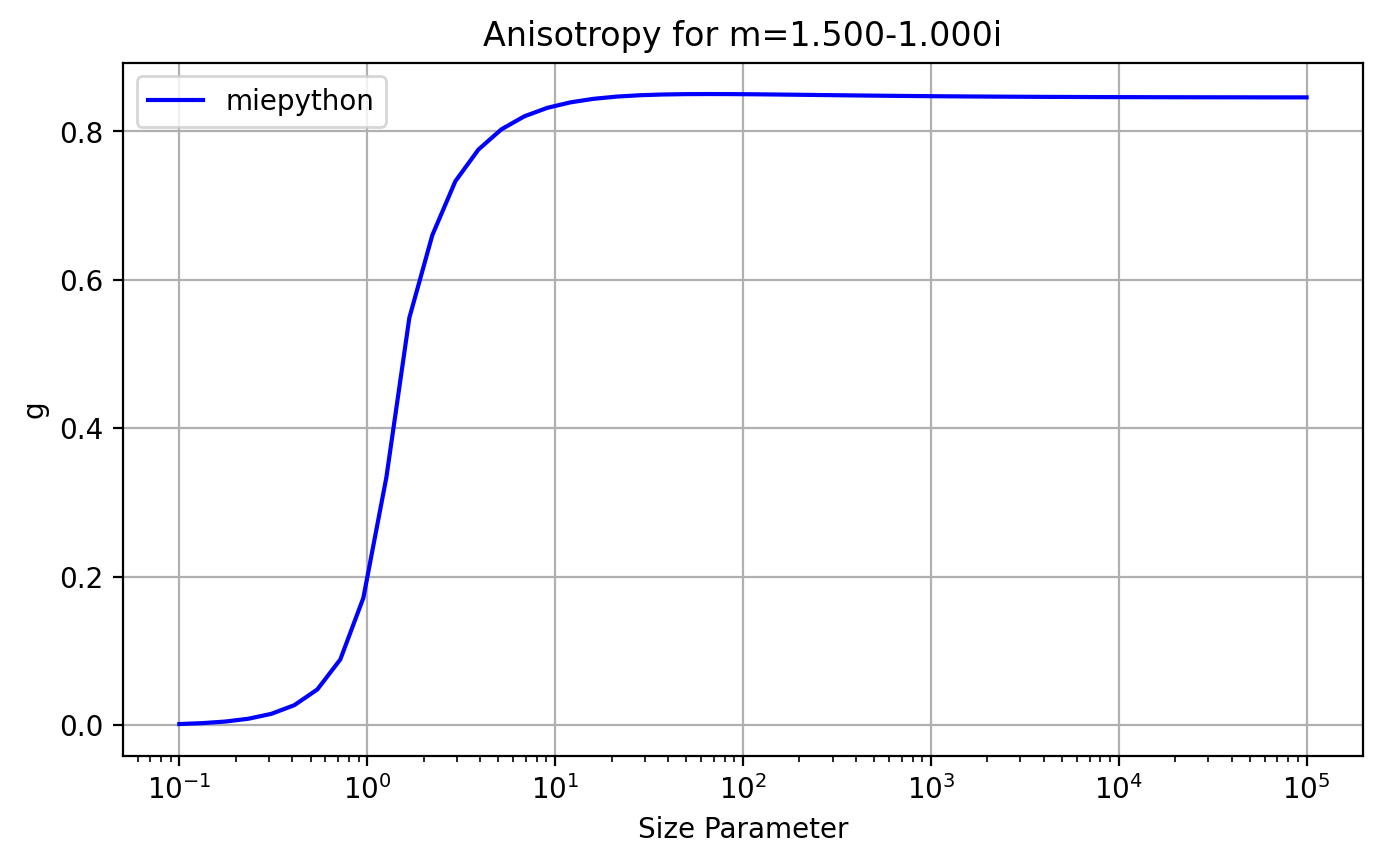

In [29]:
plt.figure(figsize=(8, 4.5))
plt.semilogx(x, g, "b", label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()

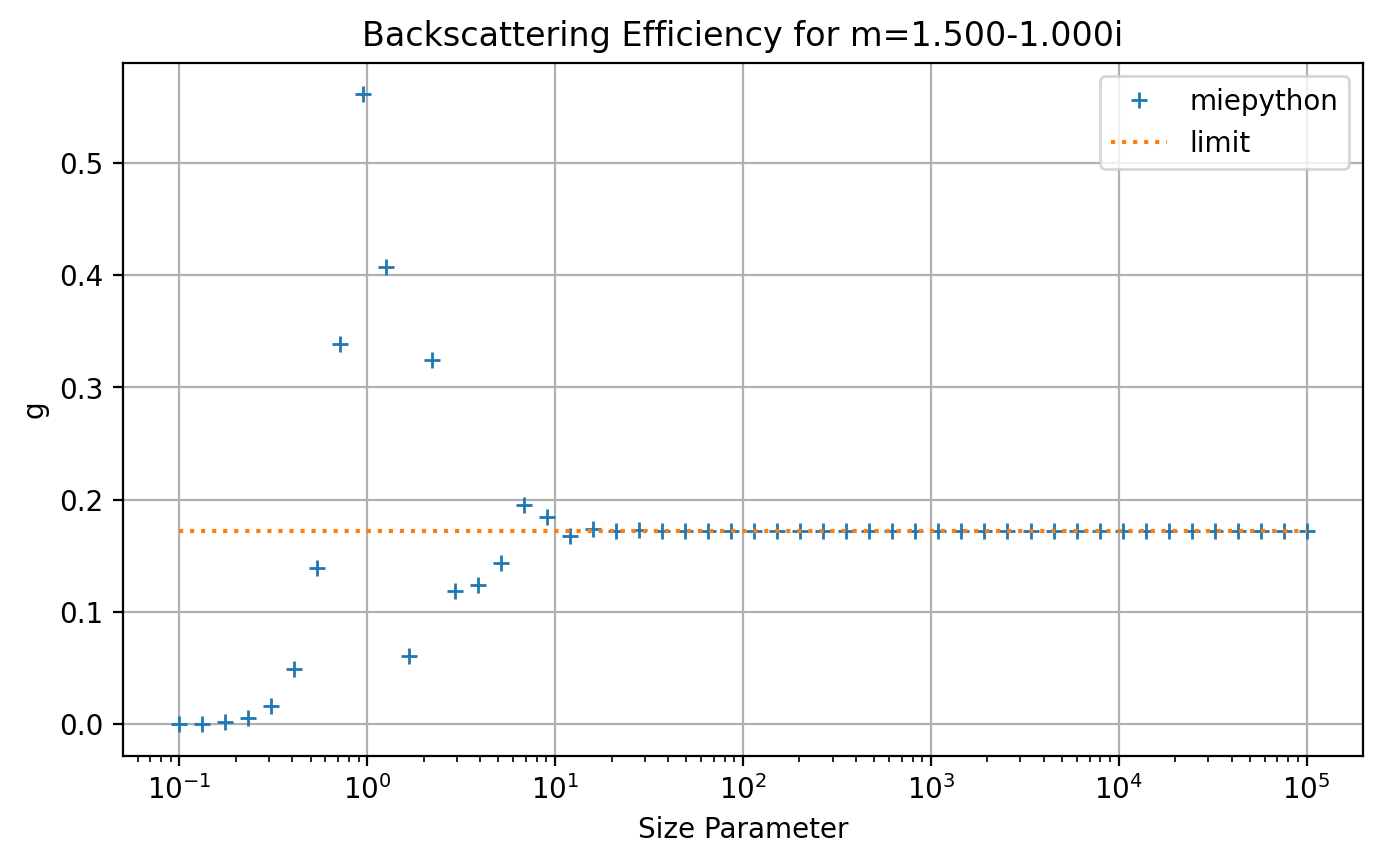

In [30]:
Qbacks = abs(m - 1) ** 2 / abs(m + 1) ** 2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8, 4.5))
plt.semilogx(x, qback, "+", label="miepython")
plt.semilogx(x, Qback, ":", label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real, abs(m.imag)))
plt.legend()
plt.grid()
plt.show()